In [1]:
from sys import exit
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, LeakyReLU, Dropout
from tensorflow.keras.models import Model
from matplotlib import pyplot as plt
# Для очистки области вывода в IPython, Jupyter, Colab
from IPython import display
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array
from tensorflow.keras.utils import normalize, to_categorical
import tensorflow as tf

In [2]:
plt_epoch = not False
(x_trn, y_trn), (x_tst, y_tst) = mnist.load_data()

def one_part(units, x):
    x = Dense(units)(x)
    x = LeakyReLU()(x)
    return Dropout(0.25)(x)

In [3]:
# model.summary()
def some_plts(imgs):
    fig, axs = plt.subplots(4, 4)
    k = -1
    for i in range(4):
        for j in range(4):
            k += 1
            img = imgs[k].reshape(28, 28)
            axs[i, j].imshow(img, cmap = 'gray')
            axs[i, j].axis('off')
    plt.subplots_adjust(wspace = 1, hspace = 0)
    plt.show()

In [4]:

print(x_trn.shape)
x_trn = x_trn.reshape(x_trn.shape[0], 28, 28, 1)
print(x_trn.shape)

(60000, 28, 28)
(60000, 28, 28, 1)


In [94]:
# Все параметры имеют заданные по умолчанию значения
#datagen = ImageDataGenerator(samplewise_center=True, data_format='channels_last')
datagen = ImageDataGenerator(featurewise_center=True, data_format='channels_last')
#datagen = ImageDataGenerator(zca_whitening=True, data_format='channels_last')
print('Настройка генератора...')
datagen.fit(x_trn)
X_y = datagen.flow(x_trn, y_trn, batch_size = len(y_trn), shuffle=False) # batch_size = 32
dset = X_y[0][0][:].astype('uint8')
#dset -= np.min(dset)

Настройка генератора...


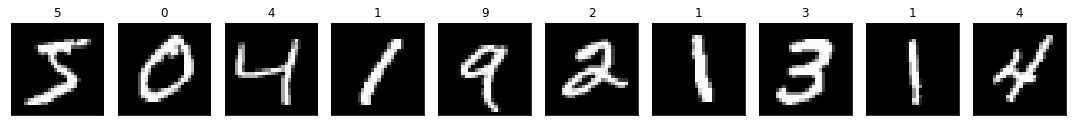

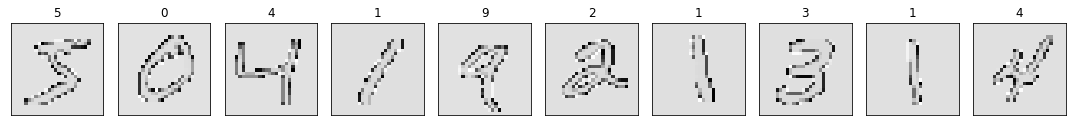

In [95]:
fig, axs = plt.subplots(nrows=1, ncols=10, figsize=(15, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axs.flat):
	ax.imshow(x_trn[i], cmap='gray')
	ax.set_title(chr(y_trn[i] + 48))
plt.tight_layout()
plt.show()

fig, axs = plt.subplots(nrows=1, ncols=10, figsize=(15, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axs.flat):
	ax.imshow(dset[i], cmap='gray')
	ax.set_title(chr(y_trn[i] + 48))
plt.tight_layout()
plt.show()

In [104]:
latent_size = 32 # Размер латентного пространста
inp = Input(shape = (784))
x = one_part(512, inp)
x = one_part(256, x)
x = one_part(128, x)
x = one_part(64, x)
x = Dense(latent_size)(x)
encoded = LeakyReLU()(x)
x = one_part(64, encoded)
x = one_part(128, x)
x = one_part(256, x)
x = one_part(512, x)
decoded = Dense(784, activation = 'sigmoid')(x)
model = Model(inputs = inp, outputs = decoded)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss = tf.keras.losses.CosineSimilarity(), metrics=['accuracy']) # nadam

In [105]:
print(np.min(dset), "\t", np.max(dset))
ds = dset.reshape(-1, 784) / 255.0
print(np.min(ds), "\t", np.max(ds))

print(np.min(x_trn), "\t",np.max(x_trn))
xt = x_trn.reshape(-1, 784) / 255.0
print(np.min(xt), "\t",np.max(xt))

0 	 255
0.0 	 1.0
0 	 255
0.0 	 1.0


In [106]:
history = model.fit(xt, ds, epochs=20, batch_size=2048)
tf.keras.backend.clear_session()

Epoch 1/20
30/30 [==============================] - 1s 16ms/step - loss: -0.9852 - accuracy: 3.6667e-04
Epoch 2/20
30/30 [==============================] - 0s 15ms/step - loss: -0.9858 - accuracy: 1.6667e-04
Epoch 3/20
30/30 [==============================] - 0s 15ms/step - loss: -0.9859 - accuracy: 1.1667e-04
Epoch 4/20
30/30 [==============================] - 0s 15ms/step - loss: -0.9860 - accuracy: 2.6667e-04
Epoch 5/20
30/30 [==============================] - 0s 15ms/step - loss: -0.9862 - accuracy: 1.1667e-04
Epoch 6/20
30/30 [==============================] - 0s 15ms/step - loss: -0.9863 - accuracy: 6.6667e-05
Epoch 7/20
30/30 [==============================] - 0s 15ms/step - loss: -0.9864 - accuracy: 1.5000e-04
Epoch 8/20
30/30 [==============================] - 0s 15ms/step - loss: -0.9865 - accuracy: 1.6667e-05
Epoch 9/20
30/30 [==============================] - 0s 15ms/step - loss: -0.9866 - accuracy: 5.0000e-05
Epoch 10/20
30/30 [==============================] - 0s 15ms/ste

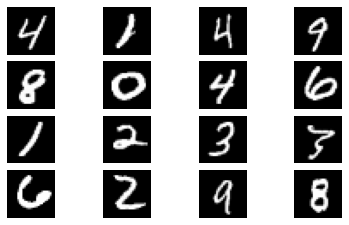

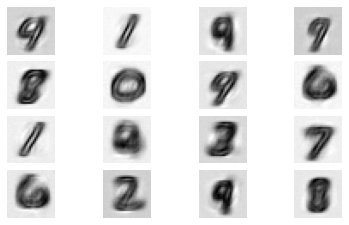

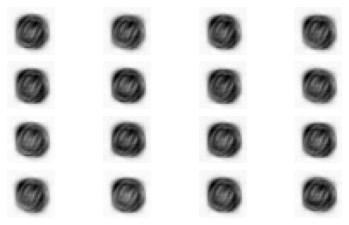

In [107]:
display.clear_output()
arr_idx = np.random.randint(0, len(y_tst), 16) # class 'numpy.ndarray'

imgs_for_test = (x_tst.reshape(-1, 784) / 255.0) [arr_idx] # class 'numpy.ndarray'

some_plts(imgs_for_test)
imgs_pedicted = model.predict(imgs_for_test)

some_plts(imgs_pedicted) # imgs_pedicted.shape = (16, 784)

# Прогноз из шума
img = np.random.uniform(0, 1, 16 * 784).reshape(16, 784)
imgs_pedicted = model.predict(img)
some_plts(imgs_pedicted)

255


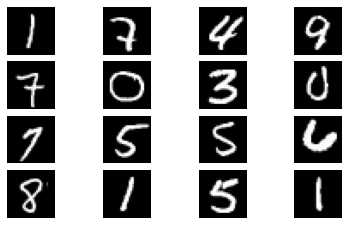

(16, 784)


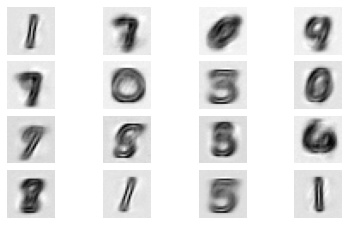

(16, 784)


In [108]:
print(np.max(dset))
arr_idx = np.random.randint(0, len(y_tst), 16) # class 'numpy.ndarray'
imgs_for_test = (x_tst.reshape(-1, 784) / 255.0)[arr_idx]
some_plts(imgs_for_test)
print(imgs_for_test.shape)
imgs_pedicted = model.predict(imgs_for_test)
some_plts(imgs_pedicted)
print(imgs_pedicted.shape)

In [109]:
print(history.history['loss'][-1])
print(history.history['accuracy'][-1])

-0.9868896007537842
3.333333370392211e-05
